In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

Lung12_generate.ipynb	   Lung5_Rep2_generate.ipynb  Lung9_Rep1_generate.ipynb
Lung13_generate.ipynb	   Lung5_Rep3_generate.ipynb  Lung9_Rep2_generate.ipynb
Lung5_Rep1_generate.ipynb  Lung6_generate.ipynb       notes.txt
/mnt/ufs18/home-144/dingjia5/projects/CosMx_lung/benchmark_generation_scripts


# Transcript Data

In [4]:
import pandas as pd


In [5]:
gene_spatial = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_tx_file.csv')
gene_spatial

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
0,1,0,6757.401589,158836.404167,3568.512700,3619.737500,11,NEAT1,0
1,1,0,5111.388989,156060.200067,1922.500100,843.533400,11,NEAT1,0
2,1,0,7860.460889,157809.338167,4671.572000,2592.671500,11,CCR2,0
3,1,0,3790.488929,155553.883467,601.600040,337.216800,11,HLA-DRA,0
4,1,0,3290.638889,158023.641667,101.750000,2806.975000,11,HLA-DRA,Membrane
...,...,...,...,...,...,...,...,...,...
37226605,30,4760,25902.627814,173480.783610,824.850037,14.116943,7,TPSAB1,Cytoplasm
37226606,30,4760,25924.052741,173477.766764,846.274963,11.100098,1,HSP90AB1,Cytoplasm
37226607,30,4760,25925.769416,173478.008219,847.991638,11.341553,6,GLUL,Cytoplasm
37226608,30,4760,25914.415290,173478.941813,836.637512,12.275146,6,ADGRE2,Cytoplasm


In [6]:
gene_spatial.shape

(37226610, 9)

In [7]:
gene_spatial.loc[gene_spatial['fov']==1].shape

(539347, 9)

In [8]:
gene_spatial.loc[gene_spatial['fov']==2].shape

(1483034, 9)

In [9]:
filtered_data_fov1_cell_ID_1 =  gene_spatial[(gene_spatial['fov']==1) & (gene_spatial['cell_ID']==1)]
filtered_data_fov1_cell_ID_1

,fov,cell_ID,x_global_px,y_global_px,x_local_px,y_local_px,z,target,CellComp
67773,1,1,4211.463839,158839.441665,1022.574950,3622.774998,11,FZD4,Cytoplasm
67774,1,1,4214.588840,158845.841666,1025.699951,3629.174999,7,RPL34,Nuclear
67775,1,1,4216.938816,158847.333333,1028.049927,3630.666666,7,CD74,Nuclear
67776,1,1,4224.397922,158843.512122,1035.509033,3626.845455,7,HLA-DQA1,Nuclear
67777,1,1,4211.308933,158851.126668,1022.420044,3634.460001,7,HLA-DQA1,Nuclear
67778,1,1,4217.288913,158850.186666,1028.400024,3633.520000,7,HLA-DPA1,Nuclear
67779,1,1,4221.674655,158848.752382,1032.785767,3632.085715,7,CD74,Nuclear
67780,1,1,4213.408908,158837.720002,1024.520020,3621.053335,6,MT1X,Cytoplasm
67781,1,1,4223.270725,158847.875758,1034.381836,3631.209091,6,HLA-DQA1,Nuclear
67782,1,1,4212.331760,158847.609526,1023.442871,3630.942860,1,MZT2A,Nuclear


In [10]:
gene_expression = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,15,38,16,29,13,51,9,17,...,18,7,9,11,14,12,31,11,13,13
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
gene_expression.shape

(100322, 982)

In [12]:
cell_boundary = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_metadata_file.csv')
cell_boundary


,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1259,1.34,1027,3631,4215.888889,158847.666667,47,35,3473,7354,715,5755,361,845,22,731,4979,26374
1,1,2,3723,1.45,2904,3618,6092.888889,158834.666667,87,60,3895,13832,18374,53158,260,1232,13,686,1110,13229
2,1,3,2010,1.62,4026,3627,7214.888889,158843.666667,68,42,2892,6048,3265,37522,378,908,19,654,10482,33824
3,1,4,3358,0.47,4230,3597,7418.888889,158813.666667,48,102,6189,16091,485,964,679,2322,5,582,6065,39512
4,1,5,1213,1.00,4258,3629,7446.888889,158845.666667,38,38,8138,19281,549,874,566,1242,17,674,3311,30136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100287,30,4756,1132,2.52,541,13,25618.777778,173479.666667,58,23,394,1569,137,1181,159,1139,0,0,4963,18071
100288,30,4757,1026,2.43,4535,13,29612.777778,173479.666667,56,23,575,1409,255,650,416,2023,0,0,4497,22633
100289,30,4758,417,1.68,16,11,25093.777778,173477.666667,32,19,395,703,123,229,214,449,0,0,4383,9674
100290,30,4759,927,2.84,159,11,25236.777778,173477.666667,54,19,125,289,42,169,98,276,0,0,1823,6964


In [13]:
cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==1)]
cell_boundary_fov_1

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1259,1.34,1027,3631,4215.888889,158847.666667,47,35,3473,7354,715,5755,361,845,22,731,4979,26374
1,1,2,3723,1.45,2904,3618,6092.888889,158834.666667,87,60,3895,13832,18374,53158,260,1232,13,686,1110,13229
2,1,3,2010,1.62,4026,3627,7214.888889,158843.666667,68,42,2892,6048,3265,37522,378,908,19,654,10482,33824
3,1,4,3358,0.47,4230,3597,7418.888889,158813.666667,48,102,6189,16091,485,964,679,2322,5,582,6065,39512
4,1,5,1213,1.00,4258,3629,7446.888889,158845.666667,38,38,8138,19281,549,874,566,1242,17,674,3311,30136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2403,1,2404,1385,1.14,5009,20,8197.888889,155236.666667,42,37,2884,10716,896,3018,209,994,0,67,2427,10114
2404,1,2405,1563,2.80,508,16,3696.888889,155232.666667,84,30,2771,12608,13080,43708,289,963,0,72,10797,24987
2405,1,2406,1374,2.13,3263,17,6451.888889,155233.666667,66,31,1168,7186,527,1412,256,723,835,2436,12508,32082
2406,1,2407,1098,1.35,4578,17,7766.888889,155233.666667,42,31,842,2757,1430,2697,369,676,1,163,12612,26814


In [14]:
type(cell_boundary_fov_1)
# cell_boundary_fov_1.to_csv('sample_fov2.csv')

pandas.core.frame.DataFrame

In [15]:
cell_boundary_fov_1.iloc[0]["CenterX_local_px"]

1027.0

In [16]:
cell_boundary_fov_1.iloc[0]["CenterY_local_px"]

3631.0

In [17]:
fov_position = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_fov_positions_file.csv')
fov_position

,fov,x_global_px,y_global_px
0,1,3188.888889,155216.666667
1,2,8661.111111,155216.666667
2,3,14133.333333,155216.666667
3,4,19605.555556,155216.666667
4,5,25077.777778,155216.666667
5,6,3188.888889,158866.666667
6,7,8661.111111,158866.666667
7,8,14133.333333,158866.666667
8,9,19605.555556,158866.666667
9,10,25077.777778,158866.666667


In [18]:
x_coordinate = [x / 10000 for x in list(fov_position["x_global_px"])]

x_coordinate

[0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 0.318888888888889,
 0.8661111111111109,
 1.41333333333333,
 1.9605555555555598,
 2.50777777777778,
 2.69666666666667,
 2.69666666666667]

In [19]:
y_coordinate = [y / 10000 for y in list(fov_position["y_global_px"])]
y_coordinate

[15.5216666666667,
 15.5216666666667,
 15.5216666666667,
 15.5216666666667,
 15.5216666666667,
 15.8866666666667,
 15.8866666666667,
 15.8866666666667,
 15.8866666666667,
 15.8866666666667,
 16.2516666666667,
 16.2516666666667,
 16.2516666666667,
 16.2516666666667,
 16.2516666666667,
 16.6166666666667,
 16.6166666666667,
 16.6166666666667,
 16.6166666666667,
 16.6166666666667,
 16.9816666666667,
 16.9816666666667,
 16.9816666666667,
 16.9816666666667,
 16.9816666666667,
 17.3466666666667,
 17.3466666666667,
 17.3466666666667,
 17.3466666666667,
 17.3466666666667,
 14.4088888888889,
 14.7738888888889]

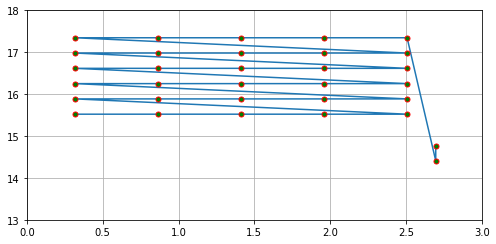

In [20]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = x_coordinate
y = y_coordinate
plt.xlim(0, 3)
plt.ylim(13, 18)
plt.grid()
plt.plot(x, y, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
plt.show()



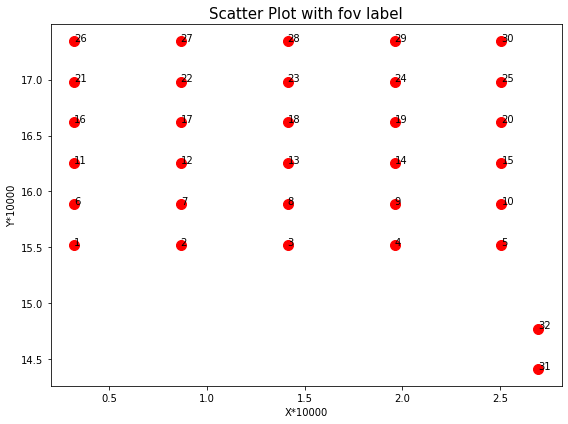

In [21]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(20)

X=np.random.randint(10, size=(5))
Y=np.random.randint(10, size=(5))

X = x_coordinate
Y = y_coordinate

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = list(fov_position["fov"])

plt.figure(figsize=(8,6))
plt.scatter(X,Y,s=100,color="red")
plt.xlabel("X*10000")
plt.ylabel("Y*10000")
plt.title("Scatter Plot with fov label",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

plt.show()

# Benchmark Generation

In [28]:
"""
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

'\nGeoMx: spot region area\n1. mean: 37456.28 μm2\n2. median: 24168.74 μm2\n'

In [29]:
"""
CosMx: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 
"""

'\nCosMx: \n1. All FOVs are the same dimension, 5472 x 3648 pixels\n2. multiply the pixel value by 0.18 um per pixel\n3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 \n'

In [30]:
"""
New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV
"""

'\nNew Benchamrk from CosMx\n1. length: 5472 pixels, width: 3648 pixels\n2. simulated spot: \n    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um\n    width: 3648 pixels / 4 = 912 pixel = 164.16 um\n    one spot area: 196.992 um * 164.16 um = 32338.2067 um2\n3. In total: 20 spots / FOV\n'

In [31]:
"""
spot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)

spot_gene_expression.csv (spot_id, gene1, gene2, gene3...)
"""

'\nspot_fov_cellId_mapping.csv (spot_id, fov, cell_Id)\n\nspot_gene_expression.csv (spot_id, gene1, gene2, gene3...)\n'

In [32]:
# fov_ids_lst = cell_boundary['fov'].unique()
# fov_ids_lst

In [33]:
# cell_boundary_fov_1 =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[0])]
# cell_boundary_fov_1

In [34]:
# new_col_val = cell_boundary_fov_1.shape[0]* [0]
# cell_boundary_fov_1.insert(loc=0, column='spot_id', value=new_col_val)

In [35]:
# print(cell_boundary_fov_1.shape[0])
# cell_boundary_fov_1


In [36]:
"""
1094.4 pixel
912 pixel

(0-1094.4, 0-912)
"""

'\n1094.4 pixel\n912 pixel\n\n(0-1094.4, 0-912)\n'

In [37]:
# def get_fov_mapping(cell_boundary_fov_11):
#     new_col_val = cell_boundary_fov_11.shape[0]* [0]
#     cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)
    
#     for i in range(cell_boundary_fov_11.shape[0]):
#         one_row_sample = cell_boundary_fov_11.iloc[i]
#         if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 1
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 2
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 3
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 4

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 5
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 6
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 7
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 8

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 9
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 10
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 11
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 12

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 13
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 14
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 15
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 16

#         elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
#             if one_row_sample["CenterY_local_px"] <= 912 * 1:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 17
#             elif one_row_sample["CenterY_local_px"] <= 912 * 2:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 18
#             elif one_row_sample["CenterY_local_px"] <= 912 * 3:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 19
#             elif one_row_sample["CenterY_local_px"] <= 912 * 4:
#                 cell_boundary_fov_11.at[i,'spot_id'] = 20

#         else:
#             print("Wrong CenterX_local_px")
#     return cell_boundary_fov_11
    


In [38]:
# # cell_boundary, 82843 rows × 20 columns
# # fov_ids_lst: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

# frames = []
# fov_ids_lst = cell_boundary['fov'].unique()
# for fov_id in fov_ids_lst:
#     fov_id = 1
#     print("fov_id:", fov_id)
#     cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
#     print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
#     cell_boundary_fov_with_spot_id = get_fov_mapping(cell_boundary_fov)
#     print("cell_boundary_fov_with_spot_id:", cell_boundary_fov_with_spot_id.shape)
# #     print(cell_boundary_fov_with_spot_id)
#     frames.append(cell_boundary_fov_with_spot_id)
#     break
# # result = pd.concat(frames)
# cell_boundary_fov_with_spot_id


In [39]:
# data_result = data_result.append({'spot_id' : 2, 'fov' : 1, 'cell_ID' : 1}, ignore_index = True)
# data_result

## 1. spot_fov_cellId_mapping.csv

In [22]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["CenterX_local_px"] <= 1094.4 * 1:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 1
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 2
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 3
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 4

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 2:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 5
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 6
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 7
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 8

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 3:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 9
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 10
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 11
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 12

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 4:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 13
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 14
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 15
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 16

        elif one_row_sample["CenterX_local_px"] <= 1094.4 * 5:
            if one_row_sample["CenterY_local_px"] <= 912 * 1:
                spot_id = 17
            elif one_row_sample["CenterY_local_px"] <= 912 * 2:
                spot_id = 18
            elif one_row_sample["CenterY_local_px"] <= 912 * 3:
                spot_id = 19
            elif one_row_sample["CenterY_local_px"] <= 912 * 4:
                spot_id = 20
        else:
            print("Wrong CenterX_local_px")
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_ID"]}, ignore_index = True)

    return data_result

        

In [23]:
data_final_result = pd.DataFrame(columns = ['spot_id', 'fov', 'cell_ID'])
data_final_result

,spot_id,fov,cell_ID


In [24]:
cell_boundary

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
0,1,1,1259,1.34,1027,3631,4215.888889,158847.666667,47,35,3473,7354,715,5755,361,845,22,731,4979,26374
1,1,2,3723,1.45,2904,3618,6092.888889,158834.666667,87,60,3895,13832,18374,53158,260,1232,13,686,1110,13229
2,1,3,2010,1.62,4026,3627,7214.888889,158843.666667,68,42,2892,6048,3265,37522,378,908,19,654,10482,33824
3,1,4,3358,0.47,4230,3597,7418.888889,158813.666667,48,102,6189,16091,485,964,679,2322,5,582,6065,39512
4,1,5,1213,1.00,4258,3629,7446.888889,158845.666667,38,38,8138,19281,549,874,566,1242,17,674,3311,30136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100287,30,4756,1132,2.52,541,13,25618.777778,173479.666667,58,23,394,1569,137,1181,159,1139,0,0,4963,18071
100288,30,4757,1026,2.43,4535,13,29612.777778,173479.666667,56,23,575,1409,255,650,416,2023,0,0,4497,22633
100289,30,4758,417,1.68,16,11,25093.777778,173477.666667,32,19,395,703,123,229,214,449,0,0,4383,9674
100290,30,4759,927,2.84,159,11,25236.777778,173477.666667,54,19,125,289,42,169,98,276,0,0,1823,6964


In [25]:
type(cell_boundary)

pandas.core.frame.DataFrame

In [26]:
fov_ids_lst = cell_boundary['fov'].unique()
fov_ids_lst

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

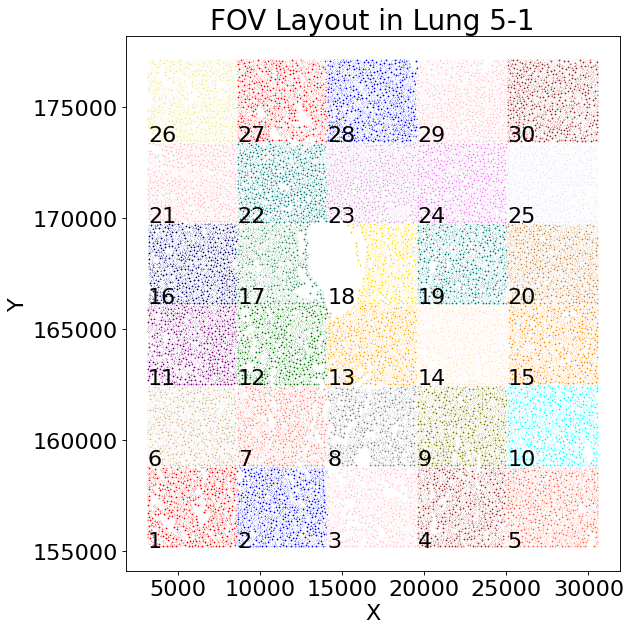

In [27]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
        "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive",\
        "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen",\
        "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki",\
         "red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", \
         "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", \
         "gold", "teal", "peru", "lightpink", "teal", "plum", "violet", "lavender", "khaki"
        ]
for i in range(len(fov_ids_lst)):
    fov_id = fov_ids_lst[i]
    X = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterX_global_px"].tolist()
    Y = cell_boundary[(cell_boundary['fov']==fov_id)]["CenterY_global_px"].tolist()

    plt.scatter(X, Y, s=30, label = fov_id, c = color[i], marker='.', alpha = None, edgecolors= 'white')
#     plt.legend()

X = fov_position["x_global_px"].tolist()
Y = fov_position["y_global_px"].tolist()

X_plus = [i+ 5472 for i in X]
Y_plus = [i+3648 for i in Y]

annotations=["Point-1","Point-2","Point-3","Point-4","Point-5"]
annotations = (fov_position["fov"]).tolist()

# plt.scatter(X,Y,s=10,color="red")
# plt.scatter(X_plus, Y_plus,s=10,color="red")
# plt.scatter(X_plus, Y,s=10,color="red")
# plt.scatter(X, Y_plus,s=10,color="red")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title("FOV Layout in Lung 5-1",fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]), size=20)

plt.savefig("../../FOV_layout/Lung5-1.png", format="png", bbox_inches="tight")
plt.show()


In [54]:
fov_ids_lst = cell_boundary['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_fov =  cell_boundary[(cell_boundary['fov']==fov_ids_lst[fov_id-1])]
    print("cell_boundary_fov_without_spot_id:", cell_boundary_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_fov)

data_final_result

fov_ids_lst: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
fov_id: 1
cell_boundary_fov_without_spot_id: (2408, 20)
fov_id: 2
cell_boundary_fov_without_spot_id: (3744, 20)
fov_id: 3
cell_boundary_fov_without_spot_id: (2942, 20)
fov_id: 4
cell_boundary_fov_without_spot_id: (3617, 20)
fov_id: 5
cell_boundary_fov_without_spot_id: (3556, 20)
fov_id: 6
cell_boundary_fov_without_spot_id: (5272, 20)
fov_id: 7
cell_boundary_fov_without_spot_id: (3705, 20)
fov_id: 8
cell_boundary_fov_without_spot_id: (3120, 20)
fov_id: 9
cell_boundary_fov_without_spot_id: (3304, 20)
fov_id: 10
cell_boundary_fov_without_spot_id: (3174, 20)
fov_id: 11
cell_boundary_fov_without_spot_id: (3946, 20)
fov_id: 12
cell_boundary_fov_without_spot_id: (3686, 20)
fov_id: 13
cell_boundary_fov_without_spot_id: (2905, 20)
fov_id: 14
cell_boundary_fov_without_spot_id: (2683, 20)
fov_id: 15
cell_boundary_fov_without_spot_id: (2693, 20)
fov_id: 16
cell_boundary_fov_without_spot_id: (3

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,12.0,1.0,2.0
2,16.0,1.0,3.0
3,16.0,1.0,4.0
4,16.0,1.0,5.0
...,...,...,...
100287,1.0,30.0,4756.0
100288,17.0,30.0,4757.0
100289,1.0,30.0,4758.0
100290,1.0,30.0,4759.0


In [55]:
data_final_result

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,12.0,1.0,2.0
2,16.0,1.0,3.0
3,16.0,1.0,4.0
4,16.0,1.0,5.0
...,...,...,...
100287,1.0,30.0,4756.0
100288,17.0,30.0,4757.0
100289,1.0,30.0,4758.0
100290,1.0,30.0,4759.0


In [56]:
data_final_result_sample = data_final_result[(data_final_result['fov']==1)]
data_final_result_sample

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,12.0,1.0,2.0
2,16.0,1.0,3.0
3,16.0,1.0,4.0
4,16.0,1.0,5.0
...,...,...,...
2403,17.0,1.0,2404.0
2404,1.0,1.0,2405.0
2405,9.0,1.0,2406.0
2406,17.0,1.0,2407.0


In [57]:
data_final_result.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')

In [58]:
data_final_result

,spot_id,fov,cell_ID
0,4.0,1.0,1.0
1,12.0,1.0,2.0
2,16.0,1.0,3.0
3,16.0,1.0,4.0
4,16.0,1.0,5.0
...,...,...,...
100287,1.0,30.0,4756.0
100288,17.0,30.0,4757.0
100289,1.0,30.0,4758.0
100290,1.0,30.0,4759.0


## 2. spot_gene_expression.csv

In [59]:
data_final_result = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
data_final_result

,Unnamed: 0,spot_id,fov,cell_ID
0,0,4.0,1.0,1.0
1,1,12.0,1.0,2.0
2,2,16.0,1.0,3.0
3,3,16.0,1.0,4.0
4,4,16.0,1.0,5.0
...,...,...,...,...
100287,100287,1.0,30.0,4756.0
100288,100288,17.0,30.0,4757.0
100289,100289,1.0,30.0,4758.0
100290,100290,1.0,30.0,4759.0


In [60]:
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,15,38,16,29,13,51,9,17,...,18,7,9,11,14,12,31,11,13,13
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20'])
fov_spot_cells_stats


,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20


In [62]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9','spot-id=10', 'spot-id=11', 'spot-id=12', 'spot-id=13','spot-id=14', 'spot-id=15', 'spot-id=16', 'spot-id=17', 'spot-id=18', 'spot-id=19','spot-id=20']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0,
 'spot-id=10': 0,
 'spot-id=11': 0,
 'spot-id=12': 0,
 'spot-id=13': 0,
 'spot-id=14': 0,
 'spot-id=15': 0,
 'spot-id=16': 0,
 'spot-id=17': 0,
 'spot-id=18': 0,
 'spot-id=19': 0,
 'spot-id=20': 0}

In [63]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)



In [64]:
fov_spot_cells_stats.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

,fov,spot-id=1,spot-id=2,spot-id=3,spot-id=4,spot-id=5,spot-id=6,spot-id=7,spot-id=8,spot-id=9,...,spot-id=11,spot-id=12,spot-id=13,spot-id=14,spot-id=15,spot-id=16,spot-id=17,spot-id=18,spot-id=19,spot-id=20
0,1,155,119,113,130,88,108,128,178,128,...,102,110,89,87,131,131,101,130,140,158
1,2,141,233,148,98,371,207,119,124,237,...,140,147,272,259,146,141,269,169,187,188
2,3,188,175,233,117,150,75,112,169,111,...,145,222,142,119,89,136,171,142,128,129
3,4,179,134,131,170,165,129,227,204,173,...,242,258,149,176,131,142,223,178,206,186
4,5,188,209,291,241,174,157,279,226,137,...,130,191,151,152,164,182,102,124,188,163
5,6,288,247,276,254,184,306,318,264,247,...,204,266,221,236,291,346,207,228,349,255
6,7,225,285,220,165,300,250,108,139,141,...,158,182,173,223,186,187,172,150,111,150
7,8,183,92,170,161,89,195,125,209,149,...,223,97,173,126,168,175,161,172,167,155
8,9,222,168,170,140,143,210,175,151,225,...,166,122,141,167,198,140,146,138,165,148
9,10,170,132,133,149,157,149,127,117,229,...,173,119,195,190,156,149,117,144,147,184


In [65]:
data_final_result[(data_final_result['fov']==fov_id)]

,Unnamed: 0,spot_id,fov,cell_ID
95532,95532,4.0,30.0,1.0
95533,95533,4.0,30.0,2.0
95534,95534,8.0,30.0,3.0
95535,95535,8.0,30.0,4.0
95536,95536,8.0,30.0,5.0
...,...,...,...,...
100287,100287,1.0,30.0,4756.0
100288,100288,17.0,30.0,4757.0
100289,100289,1.0,30.0,4758.0
100290,100290,1.0,30.0,4759.0


In [66]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = list(gene_expression.columns)[2:]
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BATF3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA'

In [67]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23


In [68]:
def get_spot_gene_expression(spot_cell_mapping, fov_expression, spot_id):
    genes_lst = list(fov_expression.columns)[2:]
    
#     gene_count_dic = {}
#     for gene_name in genes_lst:
#         gene_count_dic[gene_name] = 0
    
    cell_id_lst = spot_cell_mapping[(spot_cell_mapping['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        cell_gene_expression = cell_gene_expression.values.tolist()[0][2:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()
                
#         for gene_name in genes_lst:
#             gene_count_dic[gene_name] = gene_count_dic[gene_name] + cell_gene_expression[gene_name]
    
    return cell_gene_expression_total
    
    
    
        
    
    

In [69]:
fov_ids_lst = cell_boundary['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = data_final_result[(data_final_result['fov']==fov_id)]
    print("fov_id:", fov_id)
#     print("fov_data", fov_data)
    fov_gene_expression = gene_expression[(gene_expression['fov'] == fov_id)]
#     print("fov_gene_expression:", fov_gene_expression)
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_data, fov_gene_expression, spot_id)
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
       
#     print(spot_gene_express, len(spot_gene_express))
    
    
  

fov_id: 1
fov_id: 2
fov_id: 3
fov_id: 4
fov_id: 5
fov_id: 6
fov_id: 7
fov_id: 8
fov_id: 9
fov_id: 10
fov_id: 11
fov_id: 12
fov_id: 13
fov_id: 14
fov_id: 15
fov_id: 16
fov_id: 17
fov_id: 18
fov_id: 19
fov_id: 20
fov_id: 21
fov_id: 22
fov_id: 23
fov_id: 24
fov_id: 25
fov_id: 26
fov_id: 27
fov_id: 28
fov_id: 29
fov_id: 30


In [70]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,3,6,11,7,2,50,0,4,...,1,3,3,5,4,4,5,3,1,3
1,1,2,3,8,3,3,1,21,1,4,...,0,0,1,2,2,2,6,0,3,2
2,1,3,4,4,6,8,5,18,3,0,...,4,1,0,5,2,1,3,3,4,3
3,1,4,7,10,5,3,3,25,2,3,...,7,0,4,4,6,2,1,2,2,5
4,1,5,0,9,0,3,4,4,3,3,...,4,3,5,1,3,2,5,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30,16,12,26,51,10,12,28,15,17,...,8,5,3,18,5,7,15,7,7,8
596,30,17,8,16,13,4,3,11,13,5,...,3,6,2,10,6,2,7,4,6,1
597,30,18,2,25,31,4,8,20,21,19,...,4,8,10,6,4,5,6,7,6,10
598,30,19,1,16,18,5,3,0,18,8,...,6,5,4,9,7,7,6,3,3,4


In [71]:
spot_gene_expression.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/spot_gene_expression.csv')

## 3. Ground Truth

In [23]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [24]:
# CosMx_cell_type.columns.values[0] = "sample_id"
# CosMx_cell_type
CosMx_cell_type_sample_1 = CosMx_cell_type.iloc[sample_1_index_lst]
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97997,97998,c_1_30_4750,30,1614,2.06,64,31,889,2718,178,...,980p,31,47,1.672098,0.010128,False,Lung5,mDC,stroma,0.00
97998,97999,c_1_30_4751,30,1346,2.83,68,24,577,1840,167,...,980p,53,97,1.986772,0.020902,False,Lung5,fibroblast,stroma,0.00
97999,98000,c_1_30_4752,30,1336,1.86,54,29,309,942,77,...,980p,50,82,1.913814,0.017670,False,Lung5,mDC,lymphoid structure,0.00
98000,98001,c_1_30_4753,30,803,2.58,49,19,834,3552,142,...,980p,16,25,1.397940,0.005387,False,Lung5,B-cell,lymphoid structure,0.00


In [25]:
CosMx_cell_type_sample_1.reset_index(drop=True, inplace=True)
CosMx_cell_type_sample_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97997,97998,c_1_30_4750,30,1614,2.06,64,31,889,2718,178,...,980p,31,47,1.672098,0.010128,False,Lung5,mDC,stroma,0.00
97998,97999,c_1_30_4751,30,1346,2.83,68,24,577,1840,167,...,980p,53,97,1.986772,0.020902,False,Lung5,fibroblast,stroma,0.00
97999,98000,c_1_30_4752,30,1336,1.86,54,29,309,942,77,...,980p,50,82,1.913814,0.017670,False,Lung5,mDC,lymphoid structure,0.00
98000,98001,c_1_30_4753,30,803,2.58,49,19,834,3552,142,...,980p,16,25,1.397940,0.005387,False,Lung5,B-cell,lymphoid structure,0.00


In [26]:

for i in CosMx_cell_type_sample_1.index:
#     print(i)
    
#     sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
#     fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
#     cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])

#     CosMx_cell_type_sample_8.at[i,'sample_id']= int(CosMx_cell_type_sample_8.iloc[i]["cell_ID"].split("_")[1])
    CosMx_cell_type_sample_1.at[i,'cell_ID']= int(CosMx_cell_type_sample_1.iloc[i]["cell_ID"].split("_")[3])

CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97997,97998,4750,30,1614,2.06,64,31,889,2718,178,...,980p,31,47,1.672098,0.010128,False,Lung5,mDC,stroma,0.00
97998,97999,4751,30,1346,2.83,68,24,577,1840,167,...,980p,53,97,1.986772,0.020902,False,Lung5,fibroblast,stroma,0.00
97999,98000,4752,30,1336,1.86,54,29,309,942,77,...,980p,50,82,1.913814,0.017670,False,Lung5,mDC,lymphoid structure,0.00
98000,98001,4753,30,803,2.58,49,19,834,3552,142,...,980p,16,25,1.397940,0.005387,False,Lung5,B-cell,lymphoid structure,0.00


In [27]:
sample_1_dic = {}
for key in CosMx_cell_type_sample_1["cell_type"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'mDC': 4541,
 'endothelial': 7613,
 'pDC': 2547,
 'macrophage': 7409,
 'plasmablast': 7079,
 'epithelial': 4098,
 'neutrophil': 9925,
 'fibroblast': 13151,
 'NK': 1668,
 'T CD4 naive': 7310,
 'B-cell': 7207,
 'tumor 5': 17837,
 'T CD8 naive': 1977,
 'mast': 2462,
 'T CD4 memory': 382,
 'T CD8 memory': 43,
 'Treg': 147,
 'monocyte': 1843,
 'tumor 12': 734,
 'tumor 6': 4,
 'tumor 13': 7,
 'tumor 9': 18}

In [28]:
CosMx_cell_type_sample_1_fov_1 = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==1)]
CosMx_cell_type_sample_1_fov_1

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2320,2401,1,2183,0.87,53,61,950,2934,1912,...,980p,27,33,1.518514,0.007111,False,Lung5,neutrophil,stroma,0.01
2320,2321,2402,1,3329,1.00,65,65,1046,3057,707,...,980p,88,164,2.214844,0.035340,False,Lung5,mast,stroma,0.00
2321,2322,2403,1,1315,1.27,52,41,3432,13762,1322,...,980p,35,61,1.785330,0.013145,False,Lung5,neutrophil,stroma,0.01
2322,2323,2404,1,1385,1.14,42,37,2884,10716,896,...,980p,26,30,1.477121,0.006465,False,Lung5,NK,stroma,0.01


In [29]:
cell_type_lst = list(CosMx_cell_type_sample_1['cell_type'].unique())
print(len(cell_type_lst))
cell_type_lst

22


['mDC',
 'endothelial',
 'pDC',
 'macrophage',
 'plasmablast',
 'epithelial',
 'neutrophil',
 'fibroblast',
 'NK',
 'T CD4 naive',
 'B-cell',
 'tumor 5',
 'T CD8 naive',
 'mast',
 'T CD4 memory',
 'T CD8 memory',
 'Treg',
 'monocyte',
 'tumor 12',
 'tumor 6',
 'tumor 13',
 'tumor 9']

In [30]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + cell_type_lst
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


,fov,spot_id,mDC,endothelial,pDC,macrophage,plasmablast,epithelial,neutrophil,fibroblast,...,T CD8 naive,mast,T CD4 memory,T CD8 memory,Treg,monocyte,tumor 12,tumor 6,tumor 13,tumor 9


In [31]:
spot_celld_mapping = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/spot_fov_cellId_mapping.csv')
spot_celld_mapping

,Unnamed: 0,spot_id,fov,cell_ID
0,0,4.0,1.0,1.0
1,1,12.0,1.0,2.0
2,2,16.0,1.0,3.0
3,3,16.0,1.0,4.0
4,4,16.0,1.0,5.0
...,...,...,...,...
100287,100287,1.0,30.0,4756.0
100288,100288,17.0,30.0,4757.0
100289,100289,1.0,30.0,4758.0
100290,100290,1.0,30.0,4759.0


In [32]:
CosMx_cell_type_sample_1


,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97997,97998,4750,30,1614,2.06,64,31,889,2718,178,...,980p,31,47,1.672098,0.010128,False,Lung5,mDC,stroma,0.00
97998,97999,4751,30,1346,2.83,68,24,577,1840,167,...,980p,53,97,1.986772,0.020902,False,Lung5,fibroblast,stroma,0.00
97999,98000,4752,30,1336,1.86,54,29,309,942,77,...,980p,50,82,1.913814,0.017670,False,Lung5,mDC,lymphoid structure,0.00
98000,98001,4753,30,803,2.58,49,19,834,3552,142,...,980p,16,25,1.397940,0.005387,False,Lung5,B-cell,lymphoid structure,0.00


In [33]:
cell_id_lst = CosMx_cell_type_sample_1["cell_ID"].tolist()
len(cell_id_lst)

98002

In [37]:

# data_cell_type = CosMx_cell_type_sample_1[['fov', 'cell_ID', 'cell_type']]
# data_cell_type
# data_cell_type.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/single_cell_celltype.csv')

In [34]:
def get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type, cell_type_dic):
    existig_cell_ids_with_celltype = CosMx_cell_type['cell_ID'].unique()
    
#     import ipdb
#     ipdb.set_trace()

    for cell_id in one_spot_cell_lst:
        
        if cell_id in existig_cell_ids_with_celltype:
            one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
            cell_type = one_cell_sample["cell_type"].values[0]
            cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        else:
            print("cell id not found in groud truth!!!")
        
    return cell_type_dic



In [35]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
print(fov_ids_lst)
fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==1)]
print("fov:", fov_data)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
fov:       Unnamed: 0  spot_id  fov  cell_ID
0              0      4.0  1.0      1.0
1              1     12.0  1.0      2.0
2              2     16.0  1.0      3.0
3              3     16.0  1.0      4.0
4              4     16.0  1.0      5.0
...          ...      ...  ...      ...
2403        2403     17.0  1.0   2404.0
2404        2404      1.0  1.0   2405.0
2405        2405      9.0  1.0   2406.0
2406        2406     17.0  1.0   2407.0
2407        2407      1.0  1.0   2408.0

[2408 rows x 4 columns]
spot:       Unnamed: 0  spot_id  fov  cell_ID
1523        1523      1.0  1.0   1524.0
1527        1527      1.0  1.0   1528.0
1529        1529      1.0  1.0   1530.0
1535        1535      1.0  1.0   1536.0
1541        1541      1.0  1.0   1542.0
...          ...      ...  ...      ...
2395        2395      1.0  1.0   2396.0
2396        2396      1.0  1.0   2397.0
2

In [92]:
fov_ids_lst = spot_celld_mapping['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for fov_id in fov_ids_lst:
    fov_data = spot_celld_mapping[(spot_celld_mapping['fov']==fov_id)]

    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        one_spot_cell_lst = list(spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot
        
        CosMx_cell_type_sample_fov = CosMx_cell_type_sample_1[(CosMx_cell_type_sample_1['fov']==fov_id)]
        sample_dic = get_spot_cell_type_dic(one_spot_cell_lst, CosMx_cell_type_sample_fov, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud truth!!!
cell id not found in groud t

In [93]:
ground_truth_table

,fov,spot_id,mDC,endothelial,pDC,macrophage,plasmablast,epithelial,neutrophil,fibroblast,...,T CD8 naive,mast,T CD4 memory,T CD8 memory,Treg,monocyte,tumor 12,tumor 6,tumor 13,tumor 9
0,1.0,1.0,3.0,40.0,5.0,5.0,12.0,6.0,6.0,9.0,...,8.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,7.0,12.0,12.0,11.0,7.0,7.0,8.0,8.0,...,6.0,7.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,3.0,1.0,11.0,4.0,3.0,8.0,10.0,3.0,8.0,...,7.0,5.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.0,8.0,17.0,4.0,4.0,4.0,13.0,4.0,2.0,...,3.0,0.0,2.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0
4,1.0,5.0,3.0,27.0,0.0,9.0,3.0,10.0,5.0,2.0,...,2.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,30.0,30.0,18.0,5.0,35.0,0.0,0.0,22.0,...,47.0,1.0,4.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
596,30.0,17.0,21.0,12.0,0.0,6.0,0.0,0.0,1.0,31.0,...,23.0,2.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
597,30.0,18.0,25.0,13.0,1.0,5.0,2.0,1.0,0.0,40.0,...,23.0,3.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
598,30.0,19.0,22.0,6.0,2.0,9.0,1.0,1.0,1.0,26.0,...,18.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0


In [94]:
ground_truth_table.shape

(600, 24)

In [95]:
lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
lung13_ground_truth

,Unnamed: 0,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0,1.0,1.0,49.0,24.0,48.0,5.0,4.0,3.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,2.0,35.0,18.0,59.0,5.0,3.0,0.0,0.0,...,5.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
2,2,1.0,3.0,23.0,22.0,41.0,8.0,1.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,1.0,4.0,78.0,30.0,62.0,10.0,3.0,1.0,1.0,...,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,5.0,78.0,46.0,6.0,30.0,1.0,14.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,20.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,396,20.0,17.0,30.0,40.0,48.0,26.0,4.0,7.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0
397,397,20.0,18.0,112.0,37.0,40.0,30.0,10.0,5.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,0.0
398,398,20.0,19.0,26.0,33.0,30.0,13.0,6.0,10.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0


In [96]:
coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
coumn_names

['tumor 13',
 'fibroblast',
 'macrophage',
 'T CD4 memory',
 'T CD8 memory',
 'plasmablast',
 'B-cell',
 'mast',
 'Treg',
 'endothelial',
 'pDC',
 'T CD4 naive',
 'neutrophil',
 'T CD8 naive',
 'NK',
 'monocyte',
 'tumor 9',
 'tumor 12',
 'epithelial',
 'mDC',
 'tumor 5',
 'tumor 6']

In [97]:
first_n_column  = ground_truth_table.iloc[: , :2]
first_n_column

,fov,spot_id
0,1.0,1.0
1,1.0,2.0
2,1.0,3.0
3,1.0,4.0
4,1.0,5.0
...,...,...
595,30.0,16.0
596,30.0,17.0
597,30.0,18.0
598,30.0,19.0


In [98]:
cell_type_data = ground_truth_table.loc[:, coumn_names]
cell_type_data

,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,0.0,9.0,5.0,1.0,1.0,12.0,15.0,6.0,0.0,40.0,...,6.0,8.0,6.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0
1,0.0,8.0,11.0,3.0,0.0,7.0,7.0,7.0,0.0,12.0,...,8.0,6.0,3.0,0.0,0.0,1.0,7.0,7.0,0.0,0.0
2,0.0,8.0,3.0,3.0,0.0,8.0,17.0,5.0,3.0,11.0,...,3.0,7.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,0.0
3,0.0,2.0,4.0,2.0,0.0,4.0,10.0,0.0,4.0,17.0,...,4.0,3.0,2.0,1.0,1.0,0.0,13.0,8.0,32.0,0.0
4,0.0,2.0,9.0,0.0,0.0,3.0,1.0,1.0,0.0,27.0,...,5.0,2.0,3.0,3.0,0.0,1.0,10.0,3.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,22.0,5.0,4.0,0.0,35.0,74.0,1.0,3.0,30.0,...,0.0,47.0,2.0,2.0,0.0,0.0,0.0,30.0,0.0,0.0
596,0.0,31.0,6.0,1.0,0.0,0.0,88.0,2.0,0.0,12.0,...,1.0,23.0,5.0,6.0,0.0,0.0,0.0,21.0,0.0,0.0
597,0.0,40.0,5.0,4.0,0.0,2.0,52.0,3.0,0.0,13.0,...,0.0,23.0,4.0,5.0,0.0,0.0,1.0,25.0,0.0,0.0
598,0.0,26.0,9.0,0.0,0.0,1.0,45.0,0.0,1.0,6.0,...,1.0,18.0,2.0,12.0,0.0,0.0,1.0,22.0,1.0,0.0


In [99]:
lung1_ground_truth_table = pd.concat([first_n_column, cell_type_data], axis=1)
lung1_ground_truth_table

,fov,spot_id,tumor 13,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 5,tumor 6
0,1.0,1.0,0.0,9.0,5.0,1.0,1.0,12.0,15.0,6.0,...,6.0,8.0,6.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0
1,1.0,2.0,0.0,8.0,11.0,3.0,0.0,7.0,7.0,7.0,...,8.0,6.0,3.0,0.0,0.0,1.0,7.0,7.0,0.0,0.0
2,1.0,3.0,0.0,8.0,3.0,3.0,0.0,8.0,17.0,5.0,...,3.0,7.0,0.0,0.0,0.0,0.0,10.0,1.0,3.0,0.0
3,1.0,4.0,0.0,2.0,4.0,2.0,0.0,4.0,10.0,0.0,...,4.0,3.0,2.0,1.0,1.0,0.0,13.0,8.0,32.0,0.0
4,1.0,5.0,0.0,2.0,9.0,0.0,0.0,3.0,1.0,1.0,...,5.0,2.0,3.0,3.0,0.0,1.0,10.0,3.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,22.0,5.0,4.0,0.0,35.0,74.0,1.0,...,0.0,47.0,2.0,2.0,0.0,0.0,0.0,30.0,0.0,0.0
596,30.0,17.0,0.0,31.0,6.0,1.0,0.0,0.0,88.0,2.0,...,1.0,23.0,5.0,6.0,0.0,0.0,0.0,21.0,0.0,0.0
597,30.0,18.0,0.0,40.0,5.0,4.0,0.0,2.0,52.0,3.0,...,0.0,23.0,4.0,5.0,0.0,0.0,1.0,25.0,0.0,0.0
598,30.0,19.0,0.0,26.0,9.0,0.0,0.0,1.0,45.0,0.0,...,1.0,18.0,2.0,12.0,0.0,0.0,1.0,22.0,1.0,0.0


In [100]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [101]:
lung1_ground_truth_table = swap_columns(lung1_ground_truth_table, 'tumor 13', 'tumor 5')
lung1_ground_truth_table

,fov,spot_id,tumor 5,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,...,neutrophil,T CD8 naive,NK,monocyte,tumor 9,tumor 12,epithelial,mDC,tumor 13,tumor 6
0,1.0,1.0,0.0,9.0,5.0,1.0,1.0,12.0,15.0,6.0,...,6.0,8.0,6.0,0.0,0.0,0.0,6.0,3.0,0.0,0.0
1,1.0,2.0,0.0,8.0,11.0,3.0,0.0,7.0,7.0,7.0,...,8.0,6.0,3.0,0.0,0.0,1.0,7.0,7.0,0.0,0.0
2,1.0,3.0,3.0,8.0,3.0,3.0,0.0,8.0,17.0,5.0,...,3.0,7.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0
3,1.0,4.0,32.0,2.0,4.0,2.0,0.0,4.0,10.0,0.0,...,4.0,3.0,2.0,1.0,1.0,0.0,13.0,8.0,0.0,0.0
4,1.0,5.0,7.0,2.0,9.0,0.0,0.0,3.0,1.0,1.0,...,5.0,2.0,3.0,3.0,0.0,1.0,10.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,22.0,5.0,4.0,0.0,35.0,74.0,1.0,...,0.0,47.0,2.0,2.0,0.0,0.0,0.0,30.0,0.0,0.0
596,30.0,17.0,0.0,31.0,6.0,1.0,0.0,0.0,88.0,2.0,...,1.0,23.0,5.0,6.0,0.0,0.0,0.0,21.0,0.0,0.0
597,30.0,18.0,0.0,40.0,5.0,4.0,0.0,2.0,52.0,3.0,...,0.0,23.0,4.0,5.0,0.0,0.0,1.0,25.0,0.0,0.0
598,30.0,19.0,1.0,26.0,9.0,0.0,0.0,1.0,45.0,0.0,...,1.0,18.0,2.0,12.0,0.0,0.0,1.0,22.0,0.0,0.0


In [102]:
del lung1_ground_truth_table['tumor 6']
del lung1_ground_truth_table['tumor 9']
del lung1_ground_truth_table['tumor 12']
del lung1_ground_truth_table['tumor 13']
lung1_ground_truth_table


,fov,spot_id,tumor 5,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,0.0,9.0,5.0,1.0,1.0,12.0,15.0,6.0,0.0,40.0,5.0,29.0,6.0,8.0,6.0,0.0,6.0,3.0
1,1.0,2.0,0.0,8.0,11.0,3.0,0.0,7.0,7.0,7.0,0.0,12.0,12.0,17.0,8.0,6.0,3.0,0.0,7.0,7.0
2,1.0,3.0,3.0,8.0,3.0,3.0,0.0,8.0,17.0,5.0,3.0,11.0,4.0,22.0,3.0,7.0,0.0,0.0,10.0,1.0
3,1.0,4.0,32.0,2.0,4.0,2.0,0.0,4.0,10.0,0.0,4.0,17.0,4.0,8.0,4.0,3.0,2.0,1.0,13.0,8.0
4,1.0,5.0,7.0,2.0,9.0,0.0,0.0,3.0,1.0,1.0,0.0,27.0,0.0,7.0,5.0,2.0,3.0,3.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,22.0,5.0,4.0,0.0,35.0,74.0,1.0,3.0,30.0,18.0,100.0,0.0,47.0,2.0,2.0,0.0,30.0
596,30.0,17.0,0.0,31.0,6.0,1.0,0.0,0.0,88.0,2.0,0.0,12.0,0.0,32.0,1.0,23.0,5.0,6.0,0.0,21.0
597,30.0,18.0,0.0,40.0,5.0,4.0,0.0,2.0,52.0,3.0,0.0,13.0,1.0,27.0,0.0,23.0,4.0,5.0,1.0,25.0
598,30.0,19.0,1.0,26.0,9.0,0.0,0.0,1.0,45.0,0.0,1.0,6.0,2.0,30.0,1.0,18.0,2.0,12.0,1.0,22.0


In [103]:
lung1_ground_truth_table.rename(columns = {'tumor 5':'tumor'}, inplace = True)
lung1_ground_truth_table

/mnt/ufs18/home-144/dingjia5/anaconda3/envs/test/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,fov,spot_id,tumor,fibroblast,macrophage,T CD4 memory,T CD8 memory,plasmablast,B-cell,mast,Treg,endothelial,pDC,T CD4 naive,neutrophil,T CD8 naive,NK,monocyte,epithelial,mDC
0,1.0,1.0,0.0,9.0,5.0,1.0,1.0,12.0,15.0,6.0,0.0,40.0,5.0,29.0,6.0,8.0,6.0,0.0,6.0,3.0
1,1.0,2.0,0.0,8.0,11.0,3.0,0.0,7.0,7.0,7.0,0.0,12.0,12.0,17.0,8.0,6.0,3.0,0.0,7.0,7.0
2,1.0,3.0,3.0,8.0,3.0,3.0,0.0,8.0,17.0,5.0,3.0,11.0,4.0,22.0,3.0,7.0,0.0,0.0,10.0,1.0
3,1.0,4.0,32.0,2.0,4.0,2.0,0.0,4.0,10.0,0.0,4.0,17.0,4.0,8.0,4.0,3.0,2.0,1.0,13.0,8.0
4,1.0,5.0,7.0,2.0,9.0,0.0,0.0,3.0,1.0,1.0,0.0,27.0,0.0,7.0,5.0,2.0,3.0,3.0,10.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,30.0,16.0,0.0,22.0,5.0,4.0,0.0,35.0,74.0,1.0,3.0,30.0,18.0,100.0,0.0,47.0,2.0,2.0,0.0,30.0
596,30.0,17.0,0.0,31.0,6.0,1.0,0.0,0.0,88.0,2.0,0.0,12.0,0.0,32.0,1.0,23.0,5.0,6.0,0.0,21.0
597,30.0,18.0,0.0,40.0,5.0,4.0,0.0,2.0,52.0,3.0,0.0,13.0,1.0,27.0,0.0,23.0,4.0,5.0,1.0,25.0
598,30.0,19.0,1.0,26.0,9.0,0.0,0.0,1.0,45.0,0.0,1.0,6.0,2.0,30.0,1.0,18.0,2.0,12.0,1.0,22.0


In [104]:
lung1_ground_truth_table.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/ground_truth.csv')

## mapping between sample and real sample (should be done before 3. Groud Truth)

In [18]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [19]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 9):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = 0
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
fov: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}


In [20]:
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 1:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    if sample_id == 1:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [21]:
print(sample_cell_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))

{1: 98002, 2: 105800, 3: 97809, 4: 89975, 5: 87606, 6: 139504, 7: 71304, 8: 81236}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
98002


In [22]:
len(sample_1_index_lst)

98002

## Comparison of 980 genes between our pseudo spot and GeoMx

In [28]:
spot_gene_expression

,fov,spot_id,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,1,4,17,24,16,12,12,3,8,...,7,8,8,14,8,5,11,11,13,5
1,1,2,7,22,25,12,13,13,9,7,...,8,6,6,11,6,15,22,4,9,2
2,1,3,5,7,28,11,11,8,6,2,...,7,3,14,5,3,9,7,8,4,6
3,1,4,3,26,24,8,12,7,9,12,...,10,10,9,14,5,9,9,10,6,7
4,1,5,15,33,41,31,17,14,11,8,...,15,12,9,25,12,17,17,10,13,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,20,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,20,17,2,10,14,11,8,0,3,3,...,5,2,7,3,4,3,5,0,5,0
397,20,18,7,17,26,13,13,10,10,9,...,14,8,11,12,11,6,14,5,10,11
398,20,19,6,9,10,3,1,1,4,4,...,7,2,0,0,1,2,3,1,1,0


In [29]:
spot_gene_expression["AATK"].mean()

7.905

In [30]:
cosmx_genes_name_lst = list(gene_expression.columns)[2:]
len(cosmx_genes_name_lst)

980

In [31]:
pseudo_spot_gene_dic = {}
for gene_name in cosmx_genes_name_lst:
    pseudo_spot_gene_dic[gene_name] = spot_gene_expression[gene_name].mean()
pseudo_spot_gene_dic  

{'AATK': 7.905,
 'ABL1': 20.0475,
 'ABL2': 28.455,
 'ACE': 14.555,
 'ACE2': 13.35,
 'ACKR1': 8.8275,
 'ACKR3': 11.0875,
 'ACKR4': 10.415,
 'ACTA2': 28.185,
 'ACTG2': 9.4325,
 'ACVR1': 17.2775,
 'ACVR1B': 21.62,
 'ACVR2A': 15.1575,
 'ACVRL1': 17.68,
 'ADGRA2': 14.5125,
 'ADGRA3': 18.0175,
 'ADGRB2': 6.8375,
 'ADGRB3': 9.65,
 'ADGRD1': 12.91,
 'ADGRE1': 6.9825,
 'ADGRE2': 13.48,
 'ADGRE5': 27.5325,
 'ADGRF1': 19.2,
 'ADGRF3': 10.1275,
 'ADGRF4': 7.4875,
 'ADGRF5': 18.135,
 'ADGRG1': 26.9175,
 'ADGRG2': 4.51,
 'ADGRG3': 10.875,
 'ADGRG5': 8.335,
 'ADGRG6': 11.09,
 'ADGRL1': 15.645,
 'ADGRL2': 10.3125,
 'ADGRL4': 9.68,
 'ADGRV1': 6.675,
 'ADIPOQ': 10.4675,
 'ADIRF': 22.1575,
 'ADM2': 17.905,
 'ADORA2A': 8.2525,
 'AGR2': 11.4975,
 'AHI1': 16.3625,
 'AHR': 27.6125,
 'AKT1': 48.795,
 'ALCAM': 51.2025,
 'ANGPT1': 11.0525,
 'ANGPT2': 7.6175,
 'ANGPT4': 6.6775,
 'ANGPTL1': 12.605,
 'ANXA1': 90.33,
 'ANXA2': 234.1125,
 'ANXA4': 49.2575,
 'APOA1': 7.835,
 'APOB': 7.33,
 'APOD': 50.7925,
 'APP': 10

In [32]:
len(pseudo_spot_gene_dic)

980

In [33]:
geomx_df = pd.read_csv('../../datasets/GeoMx/kidney/Kidney_Raw_TargetCountMatrix.txt', delimiter = "\t")
geomx_df

,TargetName,disease3_scan | 001 | PanCK,disease3_scan | 001 | neg,disease3_scan | 002 | PanCK,disease3_scan | 002 | neg,disease3_scan | 003 | PanCK,disease3_scan | 003 | neg,disease3_scan | 004 | PanCK,disease3_scan | 004 | neg,disease3_scan | 005 | PanCK,...,disease1B_scan | 015 | Geometric Segment,disease1B_scan | 016 | Geometric Segment,disease1B_scan | 017 | Geometric Segment,disease1B_scan | 018 | Geometric Segment,disease1B_scan | 019 | Geometric Segment,disease1B_scan | 020 | Geometric Segment,disease1B_scan | 021 | Geometric Segment,disease1B_scan | 022 | Geometric Segment,disease1B_scan | 023 | Geometric Segment,disease1B_scan | 024 | Geometric Segment
0,PADI2,15.0,35.0,36.0,41.0,9.0,37.0,42.0,37.0,14.0,...,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
1,CYP24A1,23.0,32.0,23.0,41.0,3.0,30.0,34.0,32.0,17.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0
2,SUPT16H,35.0,66.0,46.0,61.0,20.0,39.0,79.0,66.0,43.0,...,1.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0
3,ZMIZ2,51.0,81.0,87.0,113.0,68.0,84.0,164.0,118.0,81.0,...,3.0,2.0,2.0,1.0,1.0,3.0,2.0,2.0,3.0,2.0
4,SPAG9,48.0,65.0,46.0,91.0,25.0,58.0,95.0,81.0,45.0,...,8.0,10.0,7.0,3.0,1.0,7.0,5.0,4.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18499,TMPRSS4,42.0,38.0,45.0,61.0,30.0,31.0,110.0,49.0,82.0,...,1.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,1.0
18500,ATP6V0B,90.0,140.0,74.0,166.0,38.0,74.0,133.0,98.0,73.0,...,4.0,5.0,3.0,3.0,2.0,3.0,5.0,2.0,1.0,2.0
18501,DCHS1,23.0,59.0,38.0,69.0,23.0,38.0,64.0,55.0,28.0,...,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
18502,FAM166A,21.0,39.0,31.0,63.0,20.0,29.0,35.0,43.0,25.0,...,5.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0


In [34]:
# common gene names
geomx_gene_name_list = geomx_df['TargetName'].tolist()
print("length of geomx_gene_name_list:", len(geomx_gene_name_list))

common_gene_names_lst = []
for gene_name in cosmx_genes_name_lst:
    if gene_name in geomx_gene_name_list:
        common_gene_names_lst.append(gene_name)

print(len(common_gene_names_lst))


length of geomx_gene_name_list: 18504
932


In [35]:
# gene_expression = geomx_df[(geomx_df['TargetName'] == "CYP24A1")].values.tolist()[0][1:]
# sum(gene_expression) / len(gene_expression)

In [36]:
geomx_spot_gene_dic = {}
for gene_name in common_gene_names_lst:
    geomx_one_gene_expression = geomx_df[(geomx_df['TargetName'] == gene_name)].values.tolist()[0][1:]
    geomx_spot_gene_dic[gene_name] = sum(geomx_one_gene_expression) / len(geomx_one_gene_expression)
    
geomx_spot_gene_dic  

{'AATK': 8.753246753246753,
 'ABL1': 20.48051948051948,
 'ABL2': 15.207792207792208,
 'ACE': 13.70995670995671,
 'ACE2': 21.125541125541126,
 'ACKR1': 10.70995670995671,
 'ACKR3': 8.783549783549784,
 'ACKR4': 6.532467532467533,
 'ACTA2': 37.683982683982684,
 'ACTG2': 15.8008658008658,
 'ACVR1': 19.515151515151516,
 'ACVR1B': 30.02164502164502,
 'ACVR2A': 16.98701298701299,
 'ACVRL1': 24.19047619047619,
 'ADGRA2': 13.757575757575758,
 'ADGRA3': 19.506493506493506,
 'ADGRB2': 9.480519480519481,
 'ADGRB3': 13.181818181818182,
 'ADGRD1': 10.415584415584416,
 'ADGRE1': 10.497835497835498,
 'ADGRE2': 18.155844155844157,
 'ADGRE5': 23.735930735930737,
 'ADGRF1': 16.753246753246753,
 'ADGRF3': 11.333333333333334,
 'ADGRF4': 11.090909090909092,
 'ADGRF5': 65.12987012987013,
 'ADGRG1': 59.54112554112554,
 'ADGRG2': 11.554112554112555,
 'ADGRG3': 12.380952380952381,
 'ADGRG5': 12.034632034632034,
 'ADGRG6': 15.627705627705629,
 'ADGRL1': 16.943722943722943,
 'ADGRL2': 32.54112554112554,
 'ADGRL4'

In [37]:
len(geomx_spot_gene_dic)

932

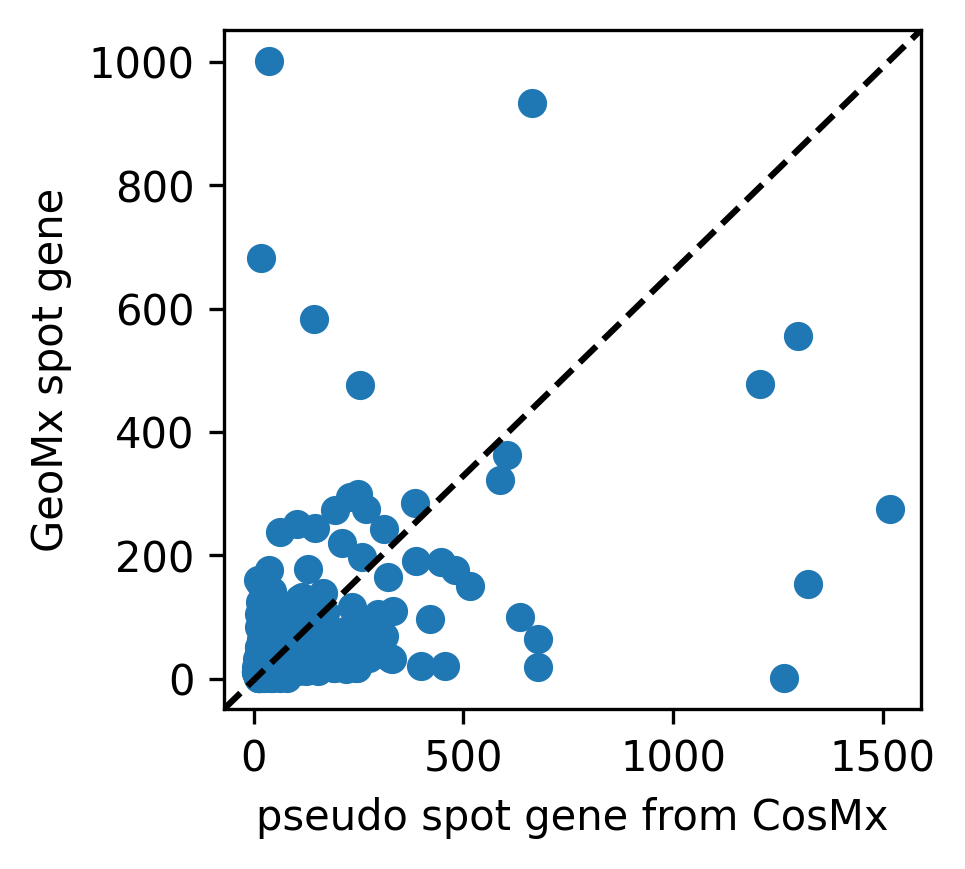

In [56]:
import matplotlib.pyplot as plt


x = []
y = []
for gene_name in common_gene_names_lst:
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

fig, ax = plt.subplots(1, 1,figsize=(3,3),dpi=300)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [39]:
len(x)

932

In [40]:
len(y)

932

corr: 0.4243927382321116


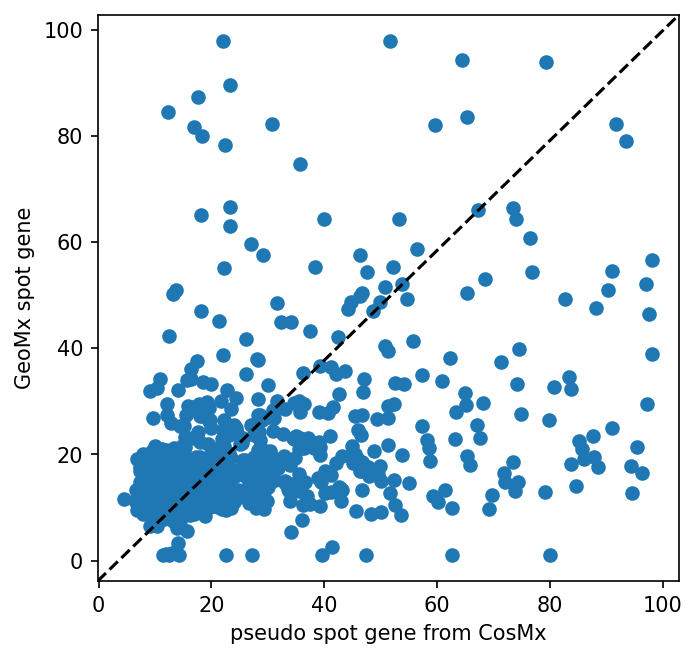

In [57]:


x = []
y = []
for gene_name in common_gene_names_lst:
    if pseudo_spot_gene_dic[gene_name] > 100:
        continue
    if geomx_spot_gene_dic[gene_name] > 100:
        continue
    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")
plt.scatter(x, y)
plt.show()

In [42]:
kidney_hk = pd.read_csv('../kidney_hk.csv')
kidney_hk

,Unnamed: 0,hks
0,1,PLA2R1
1,2,SPOCK2
2,3,MYL9
3,4,PTGDS
4,5,TGFBR2
5,6,ANXA2
6,7,DCN
7,8,FGF1
8,9,CD81
9,10,BGN


In [43]:
kidney_hk_lst = kidney_hk["hks"].tolist()

corr: 0.5320145396568767


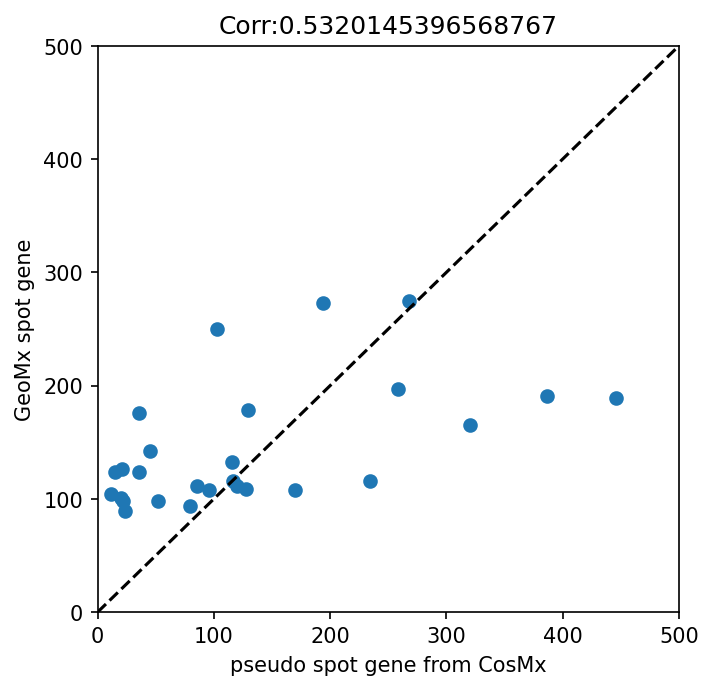

In [61]:
x = []
y = []

for gene_name in kidney_hk_lst:
    if pseudo_spot_gene_dic[gene_name] > 800:
        continue

    x.append(pseudo_spot_gene_dic[gene_name])
    y.append(geomx_spot_gene_dic[gene_name])

corr, _ = pearsonr(x, y)
print("corr:", corr)

fig, ax = plt.subplots(1, 1,figsize=(5,5),dpi=150)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")

plt.xlabel("pseudo spot gene from CosMx")
plt.ylabel("GeoMx spot gene")

plt.xlim(0,500)
plt.ylim(0,500)
plt.title('Corr:' + str(corr))

plt.scatter(x, y)
plt.show()

 ## append cell type to gene expression

In [4]:
gene_expression = pd.read_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_exprMat_file.csv')
gene_expression

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,15,38,16,29,13,51,9,17,...,18,7,9,11,14,12,31,11,13,13
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
gene_expression.shape

(100322, 982)

In [29]:
full_gene_names = gene_expression.columns.values.tolist()[2:]
len(full_gene_names)

980

In [59]:
gap_genes = []
for gene in full_gene_names:
    if gene not in filered_genes:
        gap_genes.append(gene)
gap_genes

['AATK',
 'ABL1',
 'ABL2',
 'ACE',
 'ACE2',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRB2',
 'ADGRB3',
 'ADGRD1',
 'ADGRE1',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF4',
 'ADGRF5',
 'ADGRG1',
 'ADGRG2',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'ADORA2A',
 'AGR2',
 'AHI1',
 'AHR',
 'AKT1',
 'ALCAM',
 'ANGPT1',
 'ANGPT2',
 'ANGPT4',
 'ANGPTL1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOB',
 'APOD',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARTN',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BAX',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP6',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BMX',
 'BRCA1',
 'BST1',
 'BST2',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA',
 'C1QB',
 'C1QC',
 'C5AR2',


In [56]:
type(gap_genes)

list

In [57]:
with open('../filtered_gene_list.txt') as f:
    lines = f.readlines()
    print(lines)

['TRAC\n', 'TRBC1\n', 'TRBC2\n', 'TRDC\n', 'CD2\n', 'CD3G\n', 'CD3E\n', 'CD4\n', 'CD8A\n', 'CD8B\n', 'FOXP3\n', 'EOMES\n', 'BCL6\n', 'TBX21\n', 'RORC\n', 'GATA3\n', 'PDCD1\n', 'ICOS\n', 'CTLA4\n', 'LAG3\n', 'HAVCR2\n', 'TIGIT\n', 'NRP1\n', 'CD69\n', 'GZMB\n', 'IFNG\n', 'TOX\n', 'TCF7 (TCF-1)\n', 'IL17A\n', 'NCR1\n', 'CD79A\n', 'CD79B\n', 'CD19\n', 'SDC1 (CD138)\n', 'CXCR5\n', 'LYZ2\n', 'CD14\n', 'ITGAM (CD11b)\n', 'ITGAX (CD11c)\n', 'CSF1R\n', 'CSF2\n', 'FAS\n', 'Ly6C\n', 'Ly6G\n', 'Ly6E\n', 'IFNB1\n', 'IFNA4\n', 'IFNL3\n', 'IFNGR1\n', 'IFNAR1\n', 'IL10RA\n', 'TGFBR1\n', 'CXCL9\n', 'CXCL10\n', 'MX1\n', 'ISG15\n', 'TNF\n', 'TGFB1\n', 'IL6\n', 'IL10\n', 'BATF\n', 'BATF2\n', 'BATF3\n', 'STAT1\n', 'STAT3\n', 'STAT5A\n', 'STAT5B\n', 'XCR1\n', 'CD40\n', 'CD80\n', 'CD86\n', 'MRC1\n', 'CD274\n', 'SIGLEC15\n', 'LGALS9\n', 'IRF1\n', 'IRF3\n', 'IRF5\n', 'AIM2\n', 'GSDMD\n', 'NOS2\n', 'TMEM173\n', 'TNFRSF4 (OX40)\n', 'IL3RA (CD123)\n', 'CLEC4C\n', 'FCER1A \n', 'IL7R (CD127)\n', 'MKI67\n', 'KLRG1\n

In [58]:
filered_genes = []
for line in lines:
    filered_genes.append(line.strip().split()[0].upper())
filered_genes

['TRAC',
 'TRBC1',
 'TRBC2',
 'TRDC',
 'CD2',
 'CD3G',
 'CD3E',
 'CD4',
 'CD8A',
 'CD8B',
 'FOXP3',
 'EOMES',
 'BCL6',
 'TBX21',
 'RORC',
 'GATA3',
 'PDCD1',
 'ICOS',
 'CTLA4',
 'LAG3',
 'HAVCR2',
 'TIGIT',
 'NRP1',
 'CD69',
 'GZMB',
 'IFNG',
 'TOX',
 'TCF7',
 'IL17A',
 'NCR1',
 'CD79A',
 'CD79B',
 'CD19',
 'SDC1',
 'CXCR5',
 'LYZ2',
 'CD14',
 'ITGAM',
 'ITGAX',
 'CSF1R',
 'CSF2',
 'FAS',
 'LY6C',
 'LY6G',
 'LY6E',
 'IFNB1',
 'IFNA4',
 'IFNL3',
 'IFNGR1',
 'IFNAR1',
 'IL10RA',
 'TGFBR1',
 'CXCL9',
 'CXCL10',
 'MX1',
 'ISG15',
 'TNF',
 'TGFB1',
 'IL6',
 'IL10',
 'BATF',
 'BATF2',
 'BATF3',
 'STAT1',
 'STAT3',
 'STAT5A',
 'STAT5B',
 'XCR1',
 'CD40',
 'CD80',
 'CD86',
 'MRC1',
 'CD274',
 'SIGLEC15',
 'LGALS9',
 'IRF1',
 'IRF3',
 'IRF5',
 'AIM2',
 'GSDMD',
 'NOS2',
 'TMEM173',
 'TNFRSF4',
 'IL3RA',
 'CLEC4C',
 'FCER1A',
 'IL7R',
 'MKI67',
 'KLRG1',
 'IGHM',
 'CD93',
 'FCER2A',
 'CR2',
 'IGHD',
 'NT5E',
 'PDCD1LG2',
 'SELL',
 'ATXN1',
 'CD34',
 'FLT3',
 'SLAMF1',
 'CD48',
 'FCGR3A',
 'FCGR2

In [6]:
CosMx_cell_type = pd.read_csv('../cosMX_showcase_meta.csv')
CosMx_cell_type

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,Panel,Diversity,totalcounts,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,980p,19,23,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,980p,23,26,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,980p,51,74,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,980p,48,60,1.778151,0.012929,False,Lung5,pDC,stroma,0.00
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,980p,39,52,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,980p,87,135,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,980p,60,74,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,980p,69,102,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,980p,30,31,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11


In [7]:
sample_id_full_lst = []
fov_id_full_lst = []
cell_id_full_lst = []

for i in range(CosMx_cell_type.shape[0]):
    sample_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[1])
    fov_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[2])
    cell_id = int(CosMx_cell_type.iloc[i]["cell_ID"].split("_")[3])
    sample_id_full_lst.append(sample_id)
    fov_id_full_lst.append(fov_id)
    cell_id_full_lst.append(cell_id)
    # print
    if i % 100 == 0:
        print(i)
    


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

250500
250600
250700
250800
250900
251000
251100
251200
251300
251400
251500
251600
251700
251800
251900
252000
252100
252200
252300
252400
252500
252600
252700
252800
252900
253000
253100
253200
253300
253400
253500
253600
253700
253800
253900
254000
254100
254200
254300
254400
254500
254600
254700
254800
254900
255000
255100
255200
255300
255400
255500
255600
255700
255800
255900
256000
256100
256200
256300
256400
256500
256600
256700
256800
256900
257000
257100
257200
257300
257400
257500
257600
257700
257800
257900
258000
258100
258200
258300
258400
258500
258600
258700
258800
258900
259000
259100
259200
259300
259400
259500
259600
259700
259800
259900
260000
260100
260200
260300
260400
260500
260600
260700
260800
260900
261000
261100
261200
261300
261400
261500
261600
261700
261800
261900
262000
262100
262200
262300
262400
262500
262600
262700
262800
262900
263000
263100
263200
263300
263400
263500
263600
263700
263800
263900
264000
264100
264200
264300
264400
264500
264600
264700

367800
367900
368000
368100
368200
368300
368400
368500
368600
368700
368800
368900
369000
369100
369200
369300
369400
369500
369600
369700
369800
369900
370000
370100
370200
370300
370400
370500
370600
370700
370800
370900
371000
371100
371200
371300
371400
371500
371600
371700
371800
371900
372000
372100
372200
372300
372400
372500
372600
372700
372800
372900
373000
373100
373200
373300
373400
373500
373600
373700
373800
373900
374000
374100
374200
374300
374400
374500
374600
374700
374800
374900
375000
375100
375200
375300
375400
375500
375600
375700
375800
375900
376000
376100
376200
376300
376400
376500
376600
376700
376800
376900
377000
377100
377200
377300
377400
377500
377600
377700
377800
377900
378000
378100
378200
378300
378400
378500
378600
378700
378800
378900
379000
379100
379200
379300
379400
379500
379600
379700
379800
379900
380000
380100
380200
380300
380400
380500
380600
380700
380800
380900
381000
381100
381200
381300
381400
381500
381600
381700
381800
381900
382000

485200
485300
485400
485500
485600
485700
485800
485900
486000
486100
486200
486300
486400
486500
486600
486700
486800
486900
487000
487100
487200
487300
487400
487500
487600
487700
487800
487900
488000
488100
488200
488300
488400
488500
488600
488700
488800
488900
489000
489100
489200
489300
489400
489500
489600
489700
489800
489900
490000
490100
490200
490300
490400
490500
490600
490700
490800
490900
491000
491100
491200
491300
491400
491500
491600
491700
491800
491900
492000
492100
492200
492300
492400
492500
492600
492700
492800
492900
493000
493100
493200
493300
493400
493500
493600
493700
493800
493900
494000
494100
494200
494300
494400
494500
494600
494700
494800
494900
495000
495100
495200
495300
495400
495500
495600
495700
495800
495900
496000
496100
496200
496300
496400
496500
496600
496700
496800
496900
497000
497100
497200
497300
497400
497500
497600
497700
497800
497900
498000
498100
498200
498300
498400
498500
498600
498700
498800
498900
499000
499100
499200
499300
499400

602800
602900
603000
603100
603200
603300
603400
603500
603600
603700
603800
603900
604000
604100
604200
604300
604400
604500
604600
604700
604800
604900
605000
605100
605200
605300
605400
605500
605600
605700
605800
605900
606000
606100
606200
606300
606400
606500
606600
606700
606800
606900
607000
607100
607200
607300
607400
607500
607600
607700
607800
607900
608000
608100
608200
608300
608400
608500
608600
608700
608800
608900
609000
609100
609200
609300
609400
609500
609600
609700
609800
609900
610000
610100
610200
610300
610400
610500
610600
610700
610800
610900
611000
611100
611200
611300
611400
611500
611600
611700
611800
611900
612000
612100
612200
612300
612400
612500
612600
612700
612800
612900
613000
613100
613200
613300
613400
613500
613600
613700
613800
613900
614000
614100
614200
614300
614400
614500
614600
614700
614800
614900
615000
615100
615200
615300
615400
615500
615600
615700
615800
615900
616000
616100
616200
616300
616400
616500
616600
616700
616800
616900
617000

720000
720100
720200
720300
720400
720500
720600
720700
720800
720900
721000
721100
721200
721300
721400
721500
721600
721700
721800
721900
722000
722100
722200
722300
722400
722500
722600
722700
722800
722900
723000
723100
723200
723300
723400
723500
723600
723700
723800
723900
724000
724100
724200
724300
724400
724500
724600
724700
724800
724900
725000
725100
725200
725300
725400
725500
725600
725700
725800
725900
726000
726100
726200
726300
726400
726500
726600
726700
726800
726900
727000
727100
727200
727300
727400
727500
727600
727700
727800
727900
728000
728100
728200
728300
728400
728500
728600
728700
728800
728900
729000
729100
729200
729300
729400
729500
729600
729700
729800
729900
730000
730100
730200
730300
730400
730500
730600
730700
730800
730900
731000
731100
731200
731300
731400
731500
731600
731700
731800
731900
732000
732100
732200
732300
732400
732500
732600
732700
732800
732900
733000
733100
733200
733300
733400
733500
733600
733700
733800
733900
734000
734100
734200

In [14]:
len(fov_id_full_lst)

771236

In [15]:
df2 = CosMx_cell_type.assign(sample_id=sample_id_full_lst)

In [16]:
df2 = df2.assign(fov_id=fov_id_full_lst)

In [17]:
df2 = df2.assign(cell_id=cell_id_full_lst)

In [18]:

x = df2[((df2['sample_id'] == 1) & (df2['fov_id'] == 1) & (df2['cell_id'] == 1) )]["cell_type"].values[0]

x

'mDC'

In [38]:
df2

,Unnamed: 0,cell_ID,fov,Area,AspectRatio,Width,Height,Mean.CD298,Max.CD298,Mean.G,...,log10totalcounts,background,remove_flagged_cells,patient,cell_type,niche,prop_tumor_in_100_neighbors,sample_id,fov_id,cell_id
0,1,c_1_1_1,1,1259,1.34,47,35,3473,7354,715,...,1.361728,0.004956,False,Lung5,mDC,plasmablast-enriched stroma,0.09,1,1,1
1,2,c_1_1_2,1,3723,1.45,87,60,3895,13832,18374,...,1.414973,0.005603,False,Lung5,endothelial,stroma,0.00,1,1,2
2,3,c_1_1_3,1,2010,1.62,68,42,2892,6048,3265,...,1.869232,0.015946,False,Lung5,endothelial,stroma,0.01,1,1,3
3,4,c_1_1_4,1,3358,0.47,48,102,6189,16091,485,...,1.778151,0.012929,False,Lung5,pDC,stroma,0.00,1,1,4
4,5,c_1_1_5,1,1213,1.00,38,38,8138,19281,549,...,1.716003,0.011205,False,Lung5,macrophage,stroma,0.00,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771231,771232,c_8_20_3999,20,1314,1.02,45,44,7430,9572,370,...,2.130334,0.029091,False,Lung13,T CD4 memory,immune,0.34,8,20,3999
771232,771233,c_8_20_4000,20,1549,1.71,60,35,8362,11209,161,...,1.869232,0.015946,False,Lung13,T CD4 memory,immune,0.30,8,20,4000
771233,771234,c_8_20_4001,20,2829,2.75,99,36,5158,10180,634,...,2.008600,0.021980,False,Lung13,macrophage,macrophages,0.41,8,20,4001
771234,771235,c_8_20_4003,20,1156,2.12,55,26,6339,9804,211,...,1.491362,0.006680,False,Lung13,T CD4 memory,macrophages,0.11,8,20,4003


In [39]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 9):
    sample_cell_count_dic[int(i)] = 0
    sample_fov_count_dic[int(i)] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}


In [40]:
cell_id_lst[:10]

NameError: name 'cell_id_lst' is not defined

In [41]:
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])
#     print(type(sample_id), type(fov_id), type(cell_id) )
    if sample_id in sample_cell_count_dic:
        sample_cell_count_dic[sample_id] += 1
        if fov_id not in sample_fov_count_dic[sample_id]:
            sample_fov_count_dic[sample_id].append(fov_id)
    else:
        print("wrong!!")
    
    
#     if sample_id not in sample_cell_count_dic:
#         print("wrong!!")
#         continue
#     sample_cell_count_dic[int(cell_id_lst[i].split("_")[1])] += 1
#     if fov_id not in sample_fov_count_dic[int(cell_id_lst[i].split("_")[1])]:
#         sample_fov_count_dic[int(cell_id_lst[i].split("_")[1])].append(fov_id)



#     if sample_id == 1:
#         sample_1_index_lst.append(index)
        
#     sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
#     if sample_id == 1:
#         if fov_id not in fov_lst:
#             fov_lst.append(fov_id)
    index += 1


len of cell_id_lst: 771236


In [42]:
print(sample_cell_count_dic)


{1: 98002, 2: 105800, 3: 97809, 4: 89975, 5: 87606, 6: 139504, 7: 71304, 8: 81236}


In [43]:
#sample_fov_count_dic

In [44]:
print(gene_expression.shape[0])
gene_expression_fov_1 =  gene_expression[(gene_expression['fov']==1)]


100322


In [45]:
gene_expression_fov_1

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb14,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
0,1,0,15,38,16,29,13,51,9,17,...,18,7,9,11,14,12,31,11,13,13
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,1,2404,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2405,1,2405,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2406,1,2406,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2407,1,2407,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
cell_type_lst = []
gx_sample_id = 1
for i in range(gene_expression.shape[0]):
    gx_fov = int(gene_expression.iloc[i]["fov"])
    gx_cell_ID = int(gene_expression.iloc[i]["cell_ID"])
#     print(gx_fov, gx_cell_ID)
    
    cell_type = df2[((df2['sample_id'] == 1) & (df2['fov_id'] == gx_fov) & (df2['cell_id'] == gx_cell_ID) )]["cell_type"]
    if len(cell_type)  != 0:
        cell_type_lst.append(cell_type.values[0])
    else:
        cell_type_lst.append("None")



In [50]:
len(cell_type_lst)

100322

In [51]:
final_output = gene_expression.assign(cell_type=cell_type_lst)

In [52]:
final_output

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23,cell_type
0,1,0,15,38,16,29,13,51,9,17,...,7,9,11,14,12,31,11,13,13,None
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mDC
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [53]:
final_output.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/gene_expression_with_cell_type.csv')

In [60]:
final_output

,fov,cell_ID,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,...,NegPrb15,NegPrb16,NegPrb17,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23,cell_type
0,1,0,15,38,16,29,13,51,9,17,...,7,9,11,14,12,31,11,13,13,None
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mDC
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
3,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [61]:
final_output_filered_genes = final_output.drop(gap_genes, axis=1)

In [62]:
final_output_filered_genes

,fov,cell_ID,BATF3,CD14,CD19,CD2,CD274,CD34,CD3E,CD3G,...,STAT5A,STAT5B,TBX21,TGFB1,TGFBR1,TIGIT,TNF,TNFRSF4,TOX,cell_type
0,1,0,8,135,24,15,26,53,111,21,...,26,37,9,26,19,20,14,14,11,None
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mDC
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,endothelial
4,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100317,30,4756,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100318,30,4757,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100319,30,4758,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
100320,30,4759,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [63]:
final_output_filered_genes.to_csv('../Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/new/gene_expression_with_cell_type_filtered_genes.csv')

In [74]:
cell_type_dic = {}
for i in range(final_output_filered_genes.shape[0]):
    if final_output_filered_genes.iloc[i]["fov"] == 30:
        cell_type = final_output_filered_genes.iloc[i]["cell_type"]
        if cell_type not in cell_type_dic:
            cell_type_dic[cell_type] = 1
        else:
            cell_type_dic[cell_type] += 1
cell_type_dic

{'None': 47,
 'mDC': 459,
 'plasmablast': 291,
 'macrophage': 65,
 'pDC': 125,
 'fibroblast': 738,
 'T CD8 naive': 409,
 'T CD4 naive': 998,
 'B-cell': 935,
 'endothelial': 399,
 'mast': 56,
 'NK': 56,
 'Treg': 20,
 'monocyte': 86,
 'T CD4 memory': 38,
 'tumor 12': 2,
 'neutrophil': 30,
 'T CD8 memory': 3,
 'tumor 5': 1,
 'epithelial': 3}